In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.special import erf 
import os
from scipy.stats import linregress

## 48q

In [1]:
def file_reader_ldpc(fname_in,Nq,repeat,even_odd):
    first = True
    for i_rep in range(repeat):
        fname = fname_in + "_i_%d.npz" % (i_rep)

        if os.path.exists(fname):
            npz_file = np.load(fname)
            if even_odd == "odd":
                succ_prob_word, succ_prob, p_list, Nrep = npz_file['succ_prob_word_X'], npz_file['succ_prob_X'],  npz_file['p_list'], npz_file['Nrep']
            else:
                succ_prob_word, succ_prob, p_list, Nrep = npz_file['succ_prob_word_Z'], npz_file['succ_prob_Z'],  npz_file['p_list'], npz_file['Nrep']

            if first :
                first = False
                succ_prob_avg = np.zeros((len(p_list),Nq))
                succ_prob_word_avg = np.zeros(len(p_list))
                Ntot = 0

            succ_prob_avg += succ_prob*Nrep
            succ_prob_word_avg += succ_prob_word*Nrep
            Ntot += Nrep
    if not first:    
        return succ_prob_avg/Ntot, succ_prob_word_avg/Ntot, p_list, Ntot
    else:
        return 0,0,0,0

In [658]:
repeat = 200
p_r = 0.15
Nl_small = np.arange(2,9)
Nl_large =  np.arange(12,28,4)
Nl_list = np.concatenate((Nl_small,Nl_large))
# Nl_list = np.arange(2,6,1)
ind_p_list = np.arange(0,15,1)#[8,11,14]
# ind_p_list = [8]
succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))

# plt.figure(1,figsize=(6,4))
bdy = True
for i_L, Nl in enumerate(Nl_list):
    # print(Nl)
    # f1 = "data_48q/" + "even_Nl_%d" % (Nl)
    # succ_prob_even,_, p_list_even, Ntot_even = file_reader_ldpc(f1,6,repeat,"even") 
    # succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)[0,:],:]
    # plt.plot(1-p_list_even,succ_prob_even,".", color="C%d" % (i_L), linewidth=1)#,label="N=%d, %d" % (Nl,Ntot))
        
    f2 = "data_48q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
    succ_prob_odd, _, p_list, Ntot = file_reader_ldpc(f2,6,repeat,"odd") 
    succ_prob_avg[:,i_L] = (np.mean(succ_prob_odd,axis=1))[ind_p_list]#*np.mean(succ_prob_repeater,axis=1)
    # succ_prob_avg[:,i_L] = np.mean( succ_prob_odd[ind_p_list,:]*succ_prob_repeater ,axis=1)


In [206]:

# d_list = [40]#np.linspace(10,200,10)
# cost = np.zeros((len(ind_p_list),len(d_list)))
# unit_dist = np.zeros(len(ind_p_list))

# for i_d, d_tot in enumerate(d_list):
#     for i_p, ind_p in enumerate(ind_p_list):
#         unit_dist[i_p] = -50*np.log10((1-p_list[ind_p])/(1-p_r))
#         if unit_dist[i_p]>0:
#             cost_vec = 1/(unit_dist[i_p]*succ_prob_avg[i_p,:])
#             cost[i_p,i_d] = np.interp(d_tot,Nl_list*unit_dist[i_p], cost_vec)
#             plt.figure(1)
#             plt.plot(Nl_list*unit_dist[i_p], cost_vec,color="C%d")
#             # plt.plot([d_tot,d_tot],[0,5],"k--")
#             plt.plot(d_tot,cost[i_p,i_d],"*")
#             plt.ylim(0.1,10)
#     i_dist = np.argwhere(unit_dist>0)[:,0]
#     plt.figure(2)
#     plt.plot(unit_dist[i_dist],cost[i_dist,i_d],"o-",label='d=%d km' % d_tot)

# plt.legend()
# plt.ylim(0.1,5)
# plt.xlim()
# plt.xlabel("QR dist[km]")
# plt.show()
1-p_list[ind_p_list]

array([0.78157895])

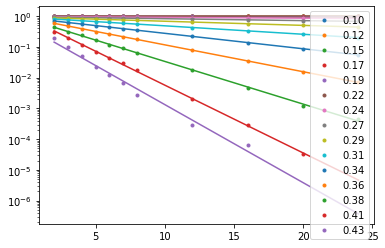

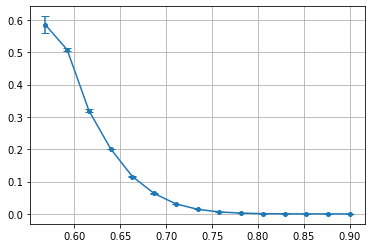

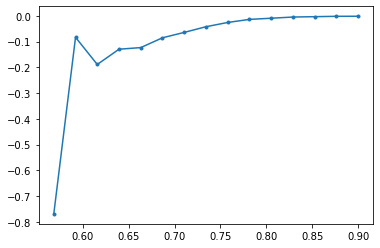

In [659]:

slope = np.zeros(len(ind_p_list))
intercept = np.zeros(len(ind_p_list))
std_err = np.zeros(len(ind_p_list))

for i_p, ind_p in enumerate(ind_p_list):
    i_s = np.argwhere(succ_prob_avg[i_p,:]>0)[:,0]
    slope[i_p], intercept[i_p], r_value, p_value, std_err[i_p] = linregress(Nl_list[i_s], np.log(succ_prob_avg[i_p,i_s]))
    plt.figure(1)
    plt.plot(Nl_list,succ_prob_avg[i_p,:],".",color="C%d" % i_p,label="%.2f" % p_list[ind_p])
    plt.plot(Nl_list, np.exp(intercept[i_p]+slope[i_p]*Nl_list),color="C%d" % i_p)
plt.yscale("log")
plt.legend()

plt.figure(2)
plt.errorbar(1-p_list[ind_p_list],-slope,std_err,marker=".",markersize=8,capsize=4)
# plt.ylim(-0.001,0.01)
plt.grid()

plt.figure(3)
plt.plot(1-p_list[ind_p_list],intercept,".-")

## interpolate large N

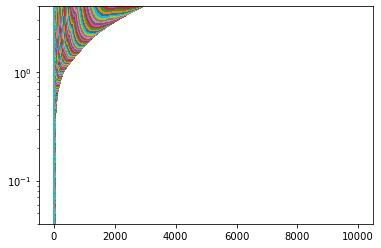

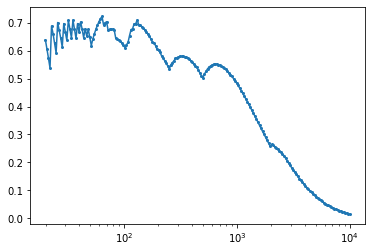

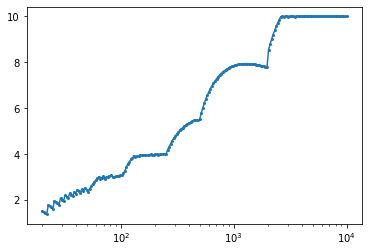

In [660]:
d_list = np.logspace(1.3,4,200)
cost = np.zeros((len(ind_p_list),len(d_list)))
unit_dist = np.zeros(len(ind_p_list))

Nl_opt = np.zeros(len(d_list))
p_opt = np.zeros(len(d_list))

N_sw = np.arange(2,1e4)
succ_prob_N = np.zeros((len(N_sw),len(ind_p_list)))
for i_N, Nl in enumerate(N_sw):        
    succ_prob_N[i_N,:] = np.exp(intercept+slope*(1+Nl))

for i_d, d_tot in enumerate(d_list):
    # print(d_tot)
    
    cost = np.zeros(len(N_sw))
    p_eff = np.zeros(len(N_sw))
    p_val = 1-(1-p_r)*10**(-0.02*d_tot/(N_sw+1))
    for i_N, Nl in enumerate(N_sw):        
        p_eff[i_N] = np.interp(p_val[i_N],p_list[ind_p_list], succ_prob_N[i_N,:])
        cost[i_N] = Nl/d_tot/p_eff[i_N]
        
    plt.figure(1)
    plt.plot(N_sw,cost,".-",label="%d" % d_tot,markersize=4)
    plt.ylim(4e-2,4e0)
    plt.yscale("log")

    i_1 = len(N_sw)-1-np.argwhere(np.diff(cost[::-1])>0)
    # print(i_1)
    if len(i_1)>0:
        Nl_opt[i_d] = N_sw[i_1[0,0]]
        p_opt[i_d] = p_eff[i_1[0,0]]
        if 10/(d_tot/Nl_opt[i_d])> 10:
            Nl_opt[i_d] = int(d_tot)
            p_opt[i_d] = p_eff[np.argwhere(N_sw==int(d_tot))]
    else:
        Nl_opt[i_d] = N_sw[0]
        p_opt[i_d] = p_eff[0]

# plt.legend()
# # plt.xlim()
# # plt.xlabel("QR dist[km]")
# plt.show()

plt.figure(2)
plt.plot(d_list,p_opt,".-",markersize=4)
plt.xscale("log")
# plt.ylim(0,1)
plt.show()

plt.figure(3)
plt.plot(d_list,10/(d_list/Nl_opt),".-",markersize=4)
# plt.plot(d_list,Nl_opt,".-",markersize=4)
plt.xscale("log")
plt.show()
# print(Nl_opt)

## interpolate slope

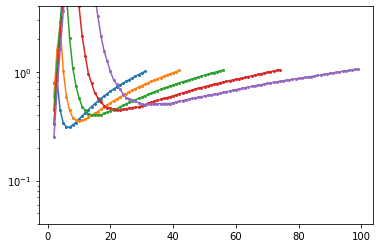

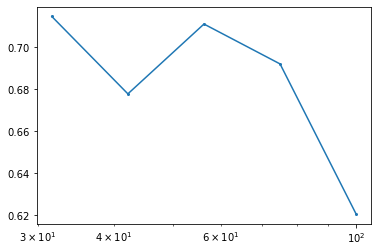

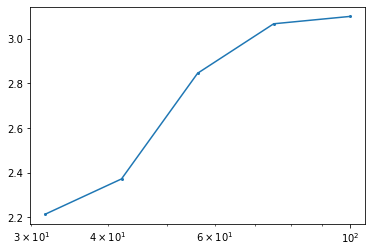

In [664]:
d_list = 10**np.linspace(1.5,2,5)#np.logspace(1.3,4,200)
cost = np.zeros((len(ind_p_list),len(d_list)))
unit_dist = np.zeros(len(ind_p_list))

Nl_opt = np.zeros(len(d_list))
p_opt = np.zeros(len(d_list))

for i_d, d_tot in enumerate(d_list):
    # print(d_tot)
    if d_tot>10:
        N_sw = np.arange(2,(d_tot/4)*4)
    else:
        N_sw = np.arange(1,20)#(d_tot/4)*10)
    cost = np.zeros(len(N_sw))
    p_eff = np.zeros(len(N_sw))
    p_val = 1-(1-p_r)*10**(-0.02*d_tot/(N_sw+1))
    # if Nl== 2000:
    #     print(1-p_val)
    slope_val = np.interp(p_val,p_list[ind_p_list], slope)
    intercept_val = np.interp(p_val,p_list[ind_p_list], intercept)
    for i_N, Nl in enumerate(N_sw):
        p_eff[i_N] = np.exp(intercept_val[i_N]+slope_val[i_N]*(1+Nl))
        cost[i_N] = Nl/d_tot/p_eff[i_N]
        
    plt.figure(1)
    plt.plot(N_sw,cost,".-",label="%d" % d_tot,markersize=4)
    plt.ylim(4e-2,4e0)
    plt.yscale("log")

    # i_1 = np.argsort(cost)
    # if p_eff[i_1[0]]> p_eff[i_1[1]]:
    #     Nl_opt[i_d] = N_sw[i_1[0]]
    #     p_opt[i_d] = p_eff[i_1[0]]
    # else:
    #     Nl_opt[i_d] = N_sw[i_1[1]]
    #     p_opt[i_d] = p_eff[i_1[1]]
    i_1 = len(N_sw)-1-np.argwhere(np.diff(cost[::-1])>0)
    # print(i_1)
    if len(i_1)>0:
        Nl_opt[i_d] = N_sw[i_1[0,0]]
        p_opt[i_d] = p_eff[i_1[0,0]]
        if 10/(d_tot/Nl_opt[i_d])> 10:
            Nl_opt[i_d] = int(d_tot)
            p_opt[i_d] = p_eff[np.argwhere(N_sw==int(d_tot))]
    else:
        Nl_opt[i_d] = N_sw[0]
        p_opt[i_d] = p_eff[0]

# plt.legend()
# # plt.xlim()
# # plt.xlabel("QR dist[km]")
# plt.show()

plt.figure(2)
plt.plot(d_list,p_opt,".-",markersize=4)
plt.xscale("log")
# plt.ylim(0,1)
plt.show()

plt.figure(3)
plt.plot(d_list,10/(d_list/Nl_opt),".-",markersize=4)
# plt.plot(d_list,Nl_opt,".-",markersize=4)
plt.xscale("log")
plt.show()
# print(Nl_opt)


In [661]:
p_opt2 = p_opt
Nl_opt2 = Nl_opt

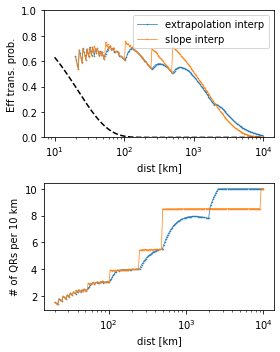

In [663]:

plt.figure(2,figsize=(4,5))
plt.subplot(211)
# plt.plot(d_list,p_opt2,".-",markersize=1,linewidth=0.7,label=r"$\eta_r =%.2f$" % (1-0.05))
# plt.plot(d_list,p_opt,".-",markersize=1,linewidth=0.7,label=r"$\eta_r =%.2f$" % (1-p_r))
plt.plot(d_list,p_opt2,".-",markersize=1,linewidth=0.7,label="extrapolation interp")
plt.plot(d_list,p_opt,".-",markersize=1,linewidth=0.7,label="slope interp")

x_plot = np.logspace(1,np.log10(np.amax(d_list)),200)
plt.plot(x_plot, 10**(-x_plot/50),"k--")
plt.xscale("log")
plt.ylabel("Eff trans. prob.")
plt.xlabel("dist [km]")
plt.ylim(0,1)
plt.legend()
# plt.show()

# plt.figure(3)
plt.subplot(212)
plt.plot(d_list,10/(d_list/Nl_opt2),".-",markersize=1,linewidth=0.7)
plt.plot(d_list,10/(d_list/Nl_opt),".-",markersize=1,linewidth=0.7)
plt.xscale("log")
plt.ylabel("# of QRs per 10 km")
plt.xlabel("dist [km]")
plt.tight_layout()
# plt.savefig("figs_Hassan/slope_vs_extrap_cost_%.2f.pdf" % (p_r))
plt.show()

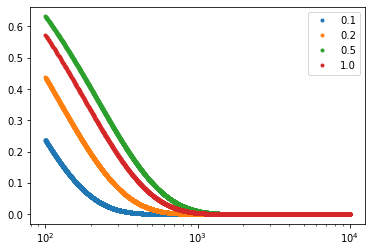

In [293]:
for dist in np.array([0.1,0.2,0.5,1]):
    p_val = 1-(1-p_r)*10**(-dist/50)
    slope_val = np.interp(p_val,p_list[ind_p_list], slope)
    intercept_val = np.interp(p_val,p_list[ind_p_list], intercept)
    Nl_max = 1e4 /dist
    Nl_min = 1e2 /dist
    Nl_sw = np.arange(Nl_min,Nl_max)
    # print(slope_val)
    p_eff = np.exp(0*intercept_val+slope_val*Nl_sw)   
    plt.plot(Nl_sw*dist,p_eff,".",label="%.1f" % dist)
plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

## 7qubit

In [426]:
def file_reader(fname_in,repeat):
    first = True
    for i_rep in range(repeat):
        fname = fname_in + "_i_%d.npz" % (i_rep)

        if os.path.exists(fname):
            npz_file = np.load(fname)
            succ_prob, p_list, Nrep = npz_file['succ_prob'], npz_file['p_list'], npz_file['Nrep']
            
            if first :
                first = False
                succ_prob_avg = np.zeros(len(p_list))
                Ntot = 0

            succ_prob_avg += succ_prob*Nrep
            Ntot += Nrep
    if not first:    
        return succ_prob_avg/Ntot, p_list, Ntot
    else:
        return 0,0,0

In [477]:
repeat = 100
p_r = 0.05
Nl_list = np.arange(2,31,2)
ind_p_list = np.arange(0,15,1)#[8,11,14]
# ind_p_list = [8]
succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))

# plt.figure(1,figsize=(6,4))
bdy = True
for i_L, Nl in enumerate(Nl_list):
    # print(Nl)
    f1 = "data_7q/" + "even_Nl_%d" % (Nl)
    succ_prob_even, p_list_even, Ntot_even = file_reader(f1,repeat) 
    succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)]

    
    f2 = "data_7q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
    succ_prob_odd, p_list, Ntot = file_reader(f2,repeat) 
    succ_prob_avg[:,i_L] = succ_prob_odd[ind_p_list]*succ_prob_repeater



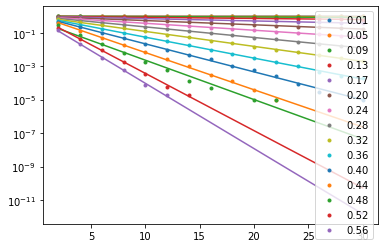

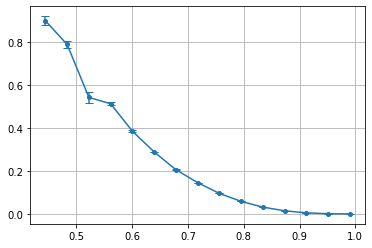

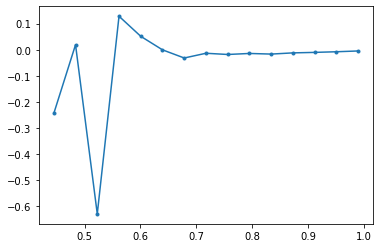

In [478]:

slope = np.zeros(len(ind_p_list))
intercept = np.zeros(len(ind_p_list))
std_err = np.zeros(len(ind_p_list))

for i_p, ind_p in enumerate(ind_p_list):
    i_s = np.argwhere(succ_prob_avg[i_p,:]>0)[:,0]
    slope[i_p], intercept[i_p], r_value, p_value, std_err[i_p] = linregress(Nl_list[i_s], np.log(succ_prob_avg[i_p,i_s]))
    plt.figure(1)
    plt.plot(Nl_list,succ_prob_avg[i_p,:],".",color="C%d" % i_p,label="%.2f" % p_list[ind_p])
    plt.plot(Nl_list, np.exp(intercept[i_p]+slope[i_p]*Nl_list),color="C%d" % i_p)
plt.yscale("log")
plt.legend()

plt.figure(2)
plt.errorbar(1-p_list[ind_p_list],-slope,std_err,marker=".",markersize=8,capsize=4)
# plt.ylim(-0.001,0.01)
plt.grid()

plt.figure(3)
plt.plot(1-p_list[ind_p_list],intercept,".-")

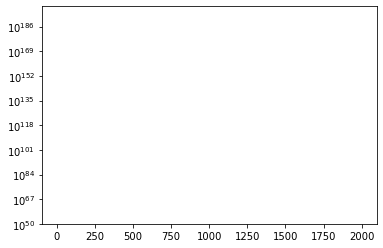

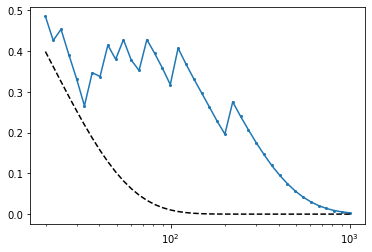

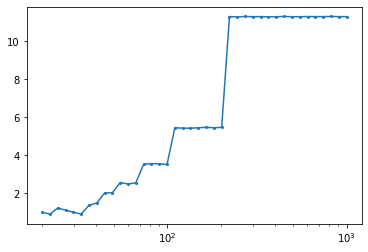

In [479]:
d_list = np.logspace(1.3,3,40)
cost = np.zeros((len(ind_p_list),len(d_list)))
unit_dist = np.zeros(len(ind_p_list))

Nl_opt = np.zeros(len(d_list))
p_opt = np.zeros(len(d_list))

for i_d, d_tot in enumerate(d_list):
    # print(d_tot)
    N_sw = np.arange(2,d_tot*2)
    cost = np.zeros(len(N_sw))
    p_eff = np.zeros(len(N_sw))
    p_val = 1-(1-p_r)*10**(-0.02*d_tot/N_sw)
    # if Nl== 2000:
    #     print(1-p_val)
    slope_val = np.interp(p_val,p_list[ind_p_list], slope)
    intercept_val = np.interp(p_val,p_list[ind_p_list], intercept)
    for i_N, Nl in enumerate(N_sw):
        p_eff[i_N] = np.exp(intercept_val[i_N]+slope_val[i_N]*Nl)
        cost[i_N] = Nl/d_tot/p_eff[i_N]
        
    plt.figure(1)
    plt.plot(N_sw,cost,".-",label="%d" % d_tot,markersize=4)
    plt.ylim(1e50,1e200)
    plt.yscale("log")

    # i_1 = np.argsort(cost)
    # if p_eff[i_1[0]]> p_eff[i_1[1]]:
    #     Nl_opt[i_d] = N_sw[i_1[0]]
    #     p_opt[i_d] = p_eff[i_1[0]]
    # else:
    #     Nl_opt[i_d] = N_sw[i_1[1]]
    #     p_opt[i_d] = p_eff[i_1[1]]
    i_1 = len(N_sw)-1-np.argwhere(np.diff(cost[::-1])>0)
    if len(i_1)>0:
        Nl_opt[i_d] = N_sw[i_1[0,0]]
        p_opt[i_d] = p_eff[i_1[0,0]]
    else:
        Nl_opt[i_d] = N_sw[0]
        p_opt[i_d] = p_eff[0]

# plt.legend()
# # plt.xlim()
# # plt.xlabel("QR dist[km]")
# plt.show()

plt.figure(2)
plt.plot(d_list,p_opt,".-",markersize=4)
plt.plot(d_list, 10**(-d_list/50),"k--")
plt.xscale("log")
# plt.ylim(0,1)
plt.show()

plt.figure(3)
plt.plot(d_list,10/(d_list/Nl_opt),".-",markersize=4)
plt.xscale("log")
plt.show()

## Comparison with Borregaard's paper

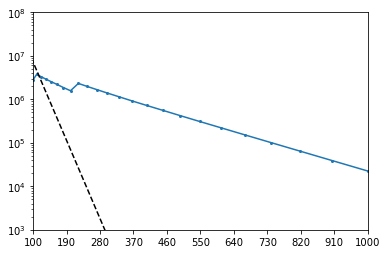

In [482]:

# d_list = np.linspace(1e2,1e3,100)
τ = 2e-9
plt.figure(2)
plt.plot(d_list,-np.log2(1-p_opt)/(100*τ),".-",markersize=4)
plt.plot(d_list,-np.log2(1-10**(-d_list/50))/τ,"k--")
plt.yscale("log")
plt.ylim(1e3,1e8)
plt.xticks(np.linspace(1e2,1e3,11))
plt.xlim(1e2,1e3)
plt.show()